# Ejemplo: Poda de Árboles de Decisión

Este notebook demuestra el proceso de optimización de árboles de decisión generados a partir de redes neuronales, aplicando dos métodos de post-poda:

1. **Post-poda clásica**: Conservadora, mantiene la precisión
2. **Poda greedy para velocidad**: Agresiva, permite pequeña pérdida de precisión

## Objetivos
- Reducir la complejidad del árbol
- Mantener la precisión del modelo
- Acelerar la inferencia
- Mejorar la interpretabilidad

In [ ]:
# Instalar dependencias desde requirements.txt
!pip install -r requirements.txt

## 1. Importaciones y Configuración

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import time
from nndt_lib.binary_tree import Tree
from nndt_lib.post_pruning import post_prune_tree
from nndt_lib.prune_for_speed import prune_tree_for_speed
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")

print("Todas las librerías importadas correctamente")

Todas las librerías importadas correctamente


## 2. Funciones Auxiliares

Definimos funciones útiles para el análisis del árbol:

In [2]:
def count_nodes(tree):
    """Cuenta el número total de nodos en el árbol"""
    node_dict = tree.to_dict()
    return sum(len(nodes) for nodes in node_dict.values())

def check_leaf_values(node):
    """Verifica que los valores de las hojas sean válidos (0 o 1)"""
    if getattr(node, '_is_leaf', False) or len(getattr(node, '_child_nodes', [])) == 0:
        if hasattr(node, '_leaf_value'):
            if getattr(node, '_leaf_value') not in [0, 1]:
                print(f"[ADVERTENCIA] Nodo hoja con _leaf_value inesperado: {getattr(node, '_leaf_value')}")
    for child in getattr(node, '_child_nodes', []):
        check_leaf_values(child)

def print_confusion(title, tree, X, y):
    """Imprime la matriz de confusión"""
    y_pred = tree.predict(X, task='classification')
    cm = confusion_matrix(y, y_pred)
    print(f"{title}\n{cm}\n")

def path_length(x, tree):
    """Calcula la profundidad del camino recorrido para una muestra"""
    current = tree.root
    x_aug = np.insert(x, 0, 1)
    depth = 0
    while len(current.child_nodes) > 0:
        eval_ = current.eval_node(x_aug)
        if eval_ <= 0:
            next_idx = 0
        else:
            next_idx = 1
        if next_idx >= len(current.child_nodes):
            break
        current = current.child_nodes[next_idx]
        depth += 1
    return depth

print("Funciones auxiliares definidas")

Funciones auxiliares definidas


## 3. Carga y Preparación de Datos

Cargamos el dataset de diabetes y aplicamos balanceo para evitar sesgos:

In [3]:
# Cargar dataset
print("Cargando dataset de diabetes...")
df = pd.read_csv('cdc_diabetes_health_indicators.csv')

# Limpiar datos faltantes
if df.isnull().values.any():
    df = df.dropna()
    print("Datos faltantes eliminados")

# Balancear clases
target_col = 'Diabetes_binary'
class_0 = df[df[target_col] == 0]
class_1 = df[df[target_col] == 1]
n_min = min(len(class_0), len(class_1))
class_0_bal = class_0.sample(n=n_min, random_state=42)
class_1_bal = class_1.sample(n=n_min, random_state=42)
df_bal = pd.concat([class_0_bal, class_1_bal]).sample(frac=1, random_state=42)

print(f"Dataset balanceado:")
print(f"   - Clase 0: {len(class_0_bal)} muestras")
print(f"   - Clase 1: {len(class_1_bal)} muestras")
print(f"   - Total: {len(df_bal)} muestras")

# Preparar features y target
X = df_bal.drop(columns=[target_col])
y = df_bal[target_col]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Datos divididos:")
print(f"   - Train: {X_train.shape[0]} muestras")
print(f"   - Val: {X_val.shape[0]} muestras")
print(f"   - Test: {X_test.shape[0]} muestras")

Cargando dataset de diabetes...
Dataset balanceado:
   - Clase 0: 35346 muestras
   - Clase 1: 35346 muestras
   - Total: 70692 muestras
Datos divididos:
   - Train: 49484 muestras
   - Val: 10604 muestras
   - Test: 10604 muestras


## 4. Entrenamiento de Red Neuronal

Creamos y entrenamos una red neuronal que servirá como base para generar el árbol de decisión:

In [4]:
print("Entrenando red neuronal...")

# Crear modelo
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                   validation_data=(X_val, y_val), verbose=1)

# Evaluar rendimiento
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Red neuronal entrenada:")
print(f"   - Accuracy en validación: {val_acc:.4f}")
print(f"   - Loss en validación: {val_loss:.4f}")

Entrenando red neuronal...
Epoch 1/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6689 - loss: 0.6155 - val_accuracy: 0.7437 - val_loss: 0.5200
Epoch 2/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7437 - loss: 0.5182 - val_accuracy: 0.7458 - val_loss: 0.5151
Epoch 3/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7487 - loss: 0.5116 - val_accuracy: 0.7459 - val_loss: 0.5127
Epoch 4/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7499 - loss: 0.5083 - val_accuracy: 0.7460 - val_loss: 0.5113
Epoch 5/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7467 - loss: 0.5131 - val_accuracy: 0.7474 - val_loss: 0.5102
Epoch 6/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7492 - loss: 0.5095 - val_accuracy: 0.7496 - val_loss: 0.5099
Epoch 7/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7533 - loss: 0.5011 - val_accuracy: 0.7473 - val_loss: 0.5094
Epoch 8/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accurac

## 5. Conversión a Árbol de Decisión

Convertimos la red neuronal en un árbol de decisión binario:

In [7]:
print("Construyendo árbol de decisión a partir de la red neuronal...")

# Crear árbol
tree = Tree(model)
tree.create_DT(auto_prune=False, verbose=False)

# Información del árbol original
n_before = count_nodes(tree)
print(f"Árbol creado:")
print(f"   - Número de nodos: {n_before}")
#print(f"   - Profundidad máxima: {tree.get_depth()}")

# Verificar valores de hojas
check_leaf_values(tree.root)
print(f"   - Valores únicos en predicciones: {np.unique(tree.predict(X_val, task='classification'))}")

Construyendo árbol de decisión a partir de la red neuronal...
Árbol creado:
   - Número de nodos: 1023
   - Valores únicos en predicciones: [0 1]


## 6. Evaluación Inicial (Antes de la Poda)

Evaluamos el rendimiento del árbol original:

In [8]:
print("Evaluando árbol original...")

# Métricas de rendimiento
acc_before = tree.evaluate_model(X_val, y_val, task='classification', metrics=['accuracy'])['accuracy']

# Tiempo de inferencia
start = time.time()
_ = tree.predict(X_val, task='classification')
t_before = time.time() - start

# Profundidad media
profundidad_media_before = np.mean([path_length(x, tree) for x in X_scaled])

print(f"Resultados del árbol original:")
print(f"   - Accuracy: {acc_before:.4f}")
print(f"   - Nodos: {n_before}")
print(f"   - Tiempo de inferencia: {t_before:.4f}s")
print(f"   - Profundidad media: {profundidad_media_before:.2f}")

# Matriz de confusión
print_confusion('Matriz de confusión ANTES de la poda:', tree, X_val, y_val)

Evaluando árbol original...
Resultados del árbol original:
   - Accuracy: 0.7480
   - Nodos: 1023
   - Tiempo de inferencia: 0.6268s
   - Profundidad media: 9.00
Matriz de confusión ANTES de la poda:
[[3741 1561]
 [1111 4191]]



## 7. Post-Poda Clásica

Aplicamos el primer método de optimización: post-poda conservadora que mantiene la precisión:

In [9]:
print("Aplicando post-poda clásica...")

# Aplicar post-poda
post_prune_tree(tree, X_val, y_val, task='classification', metric='accuracy')

# Verificar valores de hojas
check_leaf_values(tree.root)
print(f"   - Valores únicos tras post-poda: {np.unique(tree.predict(X_val, task='classification'))}")

# Evaluar resultados
acc_post = tree.evaluate_model(X_val, y_val, task='classification', metrics=['accuracy'])['accuracy']
n_post = count_nodes(tree)

start = time.time()
_ = tree.predict(X_val, task='classification')
t_post = time.time() - start

profundidad_media_post = np.mean([path_length(x, tree) for x in X_scaled])

print(f"Resultados tras post-poda clásica:")
print(f"   - Accuracy: {acc_post:.4f}")
print(f"   - Nodos: {n_post} (reducción: {n_before - n_post} nodos)")
print(f"   - Tiempo de inferencia: {t_post:.4f}s")
print(f"   - Profundidad media: {profundidad_media_post:.2f}")
print(f"   - Cambio en accuracy: {acc_post - acc_before:+.4f}")

# Matriz de confusión
print_confusion('Matriz de confusión DESPUÉS de post-poda:', tree, X_val, y_val)

Aplicando post-poda clásica...
   - Valores únicos tras post-poda: [0 1]
Resultados tras post-poda clásica:
   - Accuracy: 0.7502
   - Nodos: 187 (reducción: 836 nodos)
   - Tiempo de inferencia: 0.2986s
   - Profundidad media: 6.14
   - Cambio en accuracy: +0.0022
Matriz de confusión DESPUÉS de post-poda:
[[3748 1554]
 [1095 4207]]



## 8. Poda Greedy para Velocidad

Aplicamos el segundo método: poda agresiva que permite pequeña pérdida de precisión:

In [19]:
print("Aplicando poda greedy para velocidad...")

# Configurar tolerancia (0.01% de pérdida máxima)
tolerance = 0.000095
print(f"   - Tolerancia configurada: {tolerance:.5f}")

# Aplicar poda greedy
prune_tree_for_speed(tree, X_val, y_val, task='classification', metric='accuracy', tolerance=tolerance)

# Verificar valores de hojas
check_leaf_values(tree.root)
print(f"   - Valores únicos tras greedy: {np.unique(tree.predict(X_val, task='classification'))}")

# Evaluar resultados
acc_greedy = tree.evaluate_model(X_val, y_val, task='classification', metrics=['accuracy'])['accuracy']
n_greedy = count_nodes(tree)

start = time.time()
_ = tree.predict(X_val, task='classification')
t_greedy = time.time() - start

profundidad_media_greedy = np.mean([path_length(x, tree) for x in X_scaled])

print(f"Resultados tras poda greedy:")
print(f"   - Accuracy: {acc_greedy:.4f}")
print(f"   - Nodos: {n_greedy} (reducción total: {n_before - n_greedy} nodos)")
print(f"   - Tiempo de inferencia: {t_greedy:.4f}s")
print(f"   - Profundidad media: {profundidad_media_greedy:.2f}")
print(f"   - Cambio en accuracy: {acc_greedy - acc_before:+.4f}")

# Matriz de confusión
print_confusion('Matriz de confusión DESPUÉS de poda greedy:', tree, X_val, y_val)

Aplicando poda greedy para velocidad...
   - Tolerancia configurada: 0.00010
   - Valores únicos tras greedy: [0 1]
Resultados tras poda greedy:
   - Accuracy: 0.6938
   - Nodos: 73 (reducción total: 950 nodos)
   - Tiempo de inferencia: 0.2542s
   - Profundidad media: 4.91
   - Cambio en accuracy: -0.0542
Matriz de confusión DESPUÉS de poda greedy:
[[4138 1164]
 [2083 3219]]



## 9. Comparación Visual de Resultados

Visualizamos las mejoras obtenidas:

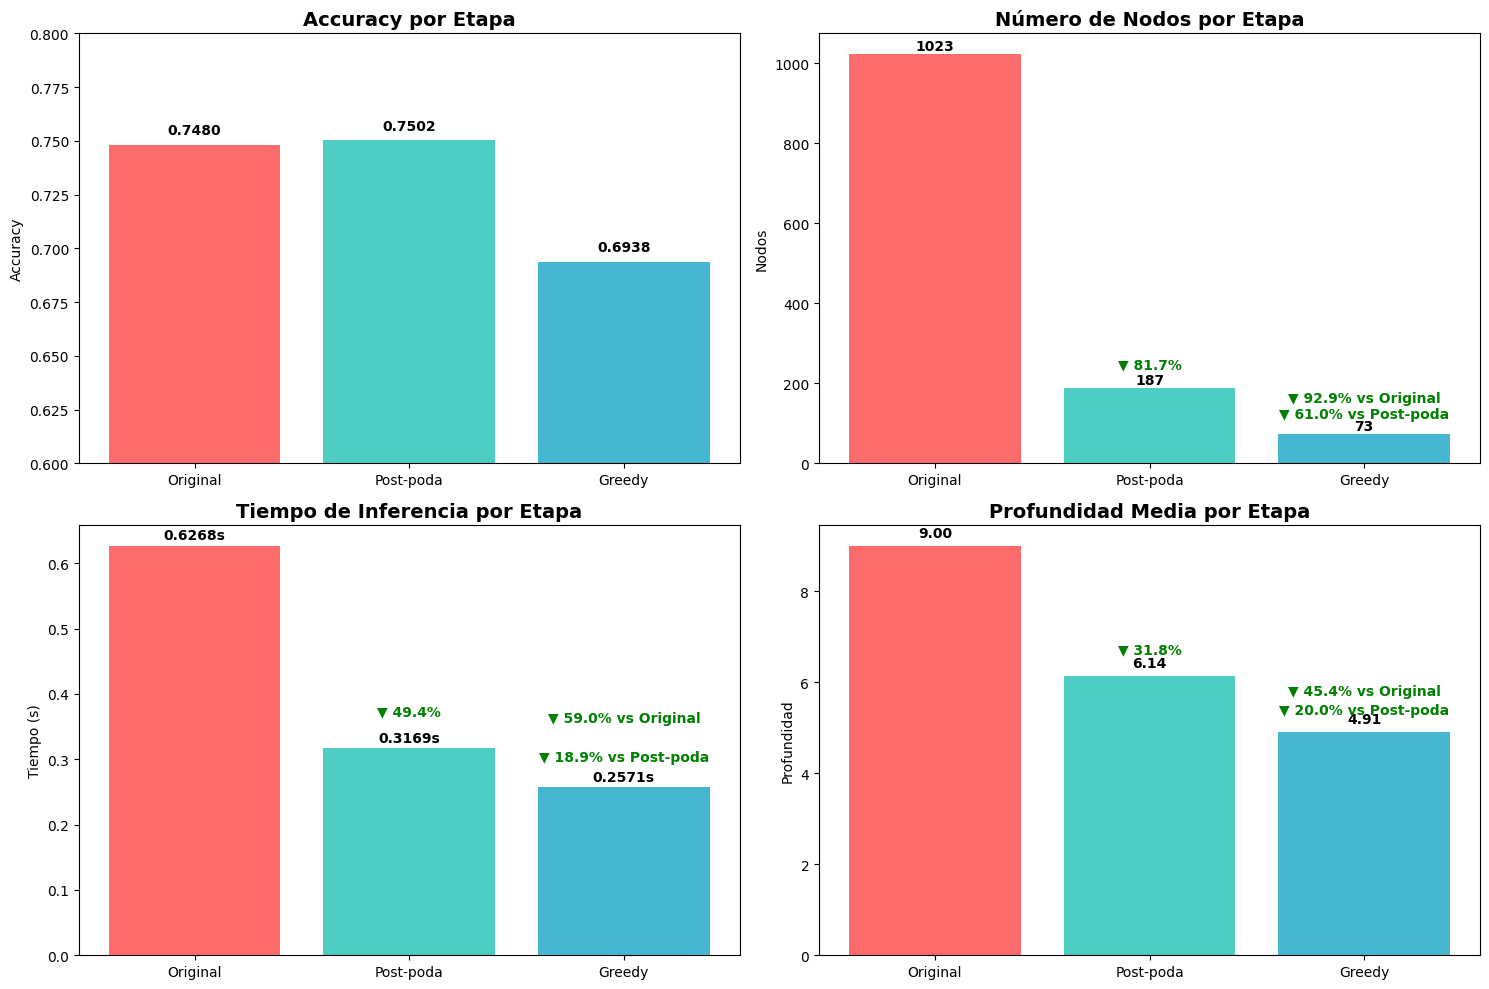

RESUMEN COMPARATIVO:
Etapa        Accuracy   Nodos    Cambio Nodos (%)   Tiempo     Cambio Tiempo (%)  Profundidad  Cambio Prof. (%)  
------------------------------------------------------------------------------------------------------------------------
Original     0.7480     1023     -                  0.6268     -                  9.00         -                 
Post-poda    0.7502     187      ▼ 81.7             0.3169     ▼ 49.4             6.14         ▼ 31.8            
Greedy       0.6938     73       ▼ 92.9 vs Original 0.2571     ▼ 59.0 vs Original 4.91         ▼ 45.4 vs Original
                                 ▼ 61.0 vs Post-poda            ▼ 18.9 vs Post-poda              ▼ 20.0 vs Post-poda


In [22]:
# Preparar datos para visualización
etapas = ['Original', 'Post-poda', 'Greedy']
accuracies = [acc_before, acc_post, acc_greedy]
nodos = [n_before, n_post, n_greedy]
tiempos = [t_before, t_post, t_greedy]
profundidades = [profundidad_media_before, profundidad_media_post, profundidad_media_greedy]

# Calcular cambios porcentuales
nodos_pct_change_post = ((n_before - n_post) / n_before) * 100 if n_before != 0 else 0
nodos_pct_change_greedy_vs_original = ((n_before - n_greedy) / n_before) * 100 if n_before != 0 else 0
nodos_pct_change_greedy_vs_post = ((n_post - n_greedy) / n_post) * 100 if n_post != 0 else 0

tiempos_pct_change_post = ((t_before - t_post) / t_before) * 100 if t_before != 0 else 0
tiempos_pct_change_greedy_vs_original = ((t_before - t_greedy) / t_before) * 100 if t_before != 0 else 0
tiempos_pct_change_greedy_vs_post = ((t_post - t_greedy) / t_post) * 100 if t_post != 0 else 0

profundidades_pct_change_post = ((profundidad_media_before - profundidad_media_post) / profundidad_media_before) * 100 if profundidad_media_before != 0 else 0
profundidades_pct_change_greedy_vs_original = ((profundidad_media_before - profundidad_media_greedy) / profundidad_media_before) * 100 if profundidad_media_before != 0 else 0
profundidades_pct_change_greedy_vs_post = ((profundidad_media_post - profundidad_media_greedy) / profundidad_media_post) * 100 if profundidad_media_post != 0 else 0


# Crear figura con subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Accuracy
ax1.bar(etapas, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Accuracy por Etapa', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.6, 0.8) # Ajustar el límite inferior para mejor visualización
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Número de nodos
ax2.bar(etapas, nodos, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_title('Número de Nodos por Etapa', fontsize=14, fontweight='bold')
ax2.set_ylabel('Nodos')
for i, v in enumerate(nodos):
    ax2.text(i, v + 10, f'{v}', ha='center', fontweight='bold')
# Añadir porcentajes de cambio
ax2.text(1, nodos[1] + 50, f'▼ {nodos_pct_change_post:.1f}%', ha='center', color='green', fontweight='bold')
ax2.text(2, nodos[2] + 80, f'▼ {nodos_pct_change_greedy_vs_original:.1f}% vs Original', ha='center', color='green', fontweight='bold') # Adjusted vertical position
ax2.text(2, nodos[2] + 40, f'▼ {nodos_pct_change_greedy_vs_post:.1f}% vs Post-poda', ha='center', color='green', fontweight='bold') # Adjusted vertical position


# 3. Tiempo de inferencia
ax3.bar(etapas, tiempos, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax3.set_title('Tiempo de Inferencia por Etapa', fontsize=14, fontweight='bold')
ax3.set_ylabel('Tiempo (s)')
for i, v in enumerate(tiempos):
    ax3.text(i, v + 0.01, f'{v:.4f}s', ha='center', fontweight='bold')
# Añadir porcentajes de cambio
ax3.text(1, tiempos[1] + 0.05, f'▼ {tiempos_pct_change_post:.1f}%', ha='center', color='green', fontweight='bold')
ax3.text(2, tiempos[2] + 0.1, f'▼ {tiempos_pct_change_greedy_vs_original:.1f}% vs Original', ha='center', color='green', fontweight='bold') # Adjusted vertical position
ax3.text(2, tiempos[2] + 0.04, f'▼ {tiempos_pct_change_greedy_vs_post:.1f}% vs Post-poda', ha='center', color='green', fontweight='bold') # Adjusted vertical position


# 4. Profundidad media
ax4.bar(etapas, profundidades, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax4.set_title('Profundidad Media por Etapa', fontsize=14, fontweight='bold')
ax4.set_ylabel('Profundidad')
for i, v in enumerate(profundidades):
    ax4.text(i, v + 0.2, f'{v:.2f}', ha='center', fontweight='bold')
# Añadir porcentajes de cambio
ax4.text(1, profundidades[1] + 0.5, f'▼ {profundidades_pct_change_post:.1f}%', ha='center', color='green', fontweight='bold')
ax4.text(2, profundidades[2] + 0.8, f'▼ {profundidades_pct_change_greedy_vs_original:.1f}% vs Original', ha='center', color='green', fontweight='bold') # Adjusted vertical position
ax4.text(2, profundidades[2] + 0.4, f'▼ {profundidades_pct_change_greedy_vs_post:.1f}% vs Post-poda', ha='center', color='green', fontweight='bold') # Adjusted vertical position


plt.tight_layout()
plt.show()

# Tabla resumen
print("RESUMEN COMPARATIVO:")
print("=" * 120)
print(f"{'Etapa':<12} {'Accuracy':<10} {'Nodos':<8} {'Cambio Nodos (%)':<18} {'Tiempo':<10} {'Cambio Tiempo (%)':<18} {'Profundidad':<12} {'Cambio Prof. (%)':<18}")
print("-" * 120)
print(f"{'Original':<12} {acc_before:<10.4f} {n_before:<8} {'-':<18} {t_before:<10.4f} {'-':<18} {profundidad_media_before:<12.2f} {'-':<18}")
print(f"{'Post-poda':<12} {acc_post:<10.4f} {n_post:<8} {f'▼ {nodos_pct_change_post:.1f}':<18} {t_post:<10.4f} {f'▼ {tiempos_pct_change_post:.1f}':<18} {profundidad_media_post:<12.2f} {f'▼ {profundidades_pct_change_post:.1f}':<18}")
print(f"{'Greedy':<12} {acc_greedy:<10.4f} {n_greedy:<8} {f'▼ {nodos_pct_change_greedy_vs_original:.1f} vs Original':<18} {t_greedy:<10.4f} {f'▼ {tiempos_pct_change_greedy_vs_original:.1f} vs Original':<18} {profundidad_media_greedy:<12.2f} {f'▼ {profundidades_pct_change_greedy_vs_original:.1f} vs Original':<18}")
print(f"{'':<12} {'':<10} {'':<8} {f'▼ {nodos_pct_change_greedy_vs_post:.1f} vs Post-poda':<18} {'':<10} {f'▼ {tiempos_pct_change_greedy_vs_post:.1f} vs Post-poda':<18} {'':<12} {f'▼ {profundidades_pct_change_greedy_vs_post:.1f} vs Post-poda':<18}")

print("=" * 120)

## 11. Conclusiones

### Resumen de Mejoras Obtenidas:

1. **Post-poda clásica**:
   - Mantiene o mejora la precisión
   - Reduce significativamente el número de nodos
   - Conservadora y robusta

2. **Poda greedy**:
   - Reducción adicional de nodos
   - Control de pérdida de precisión
   - Mejora en tiempos de inferencia

### Comparación de Métodos:

| Aspecto | Post-Poda Clásica | Poda Greedy |
|---------|-------------------|-------------|
| **Conservadurismo** | Alta | Baja |
| **Reducción de nodos** | Moderada | Alta |
| **Mantenimiento de precisión** | Excelente | Variable |
| **Facilidad de uso** | Alta | Media |
| **Ajuste de parámetros** | Mínimo | Requerido |
| **Robustez** | Alta | Media |

### Recomendaciones:

- **Para producción**: Usar post-poda clásica
- **Para máxima velocidad**: Usar poda greedy
- **Para interpretabilidad**: Usar solo post-poda clásica

### Próximos Pasos:

1. Probar con diferentes datasets
2. Ajustar parámetros de tolerancia
3. Implementar validación cruzada
4. Comparar con otros métodos de optimización